# Fock space: 
## Kok quantum-enhanced telescope example

Implements the original GJC scheme to compute & reproduce the classical Fisher information of this. 
Here, a phase shift is encoded into a photon in the superposition of being collected by the left and right telescopes. 
An ancilla photon is distributed in a quantum network between the telescopes, and enables a quantum interference measurement between the two photon arriving the telescope modes.

<!-- ![10.1103/PhysRevLett.109.070503](assets/gjc_schematic.png) -->
<img src="assets/gjc_schematic.png" width=400 />
Source: 10.1103/PhysRevLett.109.070503

In [1]:
import functools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import polars as pl
import tqdm
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import LOPC, FockState, Phase
from squint.utils import print_nonzero_entries

jax.config.update("jax_enable_x64", True)

In [2]:
cut = 4
circuit = Circuit()

m = 3

# we add in the stellar photon, which is in an even superposition of spatial modes 0 and 2 (left and right telescopes)
for i in range(m):
    circuit.add(
        FockState(
            wires=(
                i,
                m + i,
            ),
            n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
        )
    )

circuit.add(Phase(wires=(0,), phi=0.01), "phase")


# circuit.add(
#     BeamSplitter(
#         wires=tuple(range(0, m)),
#         r=0.1
#     )
# )
# circuit.add(
#     BeamSplitter(
#         wires=tuple(range(m, 2*m)),
#         r=0.1
#     )
# )
circuit.add(LOPC(wires=tuple(range(0, m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))
circuit.add(LOPC(wires=tuple(range(m, 2 * m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))


# we split out the params which can be varied (in this example, it is just the "phase" phi value), and all the static parameters (wires, etc.)
# params, static = partition_op(circuit, "phase")
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=cut, optimize="greedy")  # .jit()
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])
pprint(params)

Circuit(
  ops={
│   0:
│   FockState(
│     wires=(None, None),
│     n=[(None, (None, None)), (None, (None, None))]
│   ),
│   1:
│   FockState(
│     wires=(None, None),
│     n=[(None, (None, None)), (None, (None, None))]
│   ),
│   2:
│   FockState(
│     wires=(None, None),
│     n=[(None, (None, None)), (None, (None, None))]
│   ),
│   'phase':
│   Phase(wires=(None,), phi=weak_f64[]),
│   4:
│   LOPC(wires=(None, None, None), rs=f64[3]),
│   5:
│   LOPC(wires=(None, None, None), rs=f64[3])
  },
  _backend=None
)

In [3]:
# ket = sim.amplitudes.grad(params)
prob = sim.prob.forward(params)
# grad = sim.prob.grad(params)

print_nonzero_entries(prob)

Basis: [0 0 0 0 0 3], Value: 7.241596176754683e-05
Basis: [0 0 0 0 1 2], Value: 0.0023357407189905643
Basis: [0 0 0 0 2 1], Value: 0.0023357407189905643
Basis: [0 0 0 0 3 0], Value: 7.241596176754683e-05
Basis: [0 0 0 1 0 2], Value: 0.0023357407189905643
Basis: [0 0 0 1 1 1], Value: 0.11076831817626953
Basis: [0 0 0 1 2 0], Value: 0.0023357407189905643
Basis: [0 0 0 2 0 1], Value: 0.0023357407189905643
Basis: [0 0 0 2 1 0], Value: 0.0023357407189905643
Basis: [0 0 0 3 0 0], Value: 7.241596176754683e-05
Basis: [0 0 1 0 0 2], Value: 0.0002172430686186999
Basis: [0 0 1 0 1 1], Value: 0.004676108248531818
Basis: [0 0 1 0 2 0], Value: 0.0023309995885938406
Basis: [0 0 1 1 0 1], Value: 0.004666739609092474
Basis: [0 0 1 1 1 0], Value: 0.11077316105365753
Basis: [0 0 1 2 0 0], Value: 0.002335743745788932
Basis: [0 0 2 0 0 1], Value: 0.00021724309772253036
Basis: [0 0 2 0 1 0], Value: 0.0023404848761856556
Basis: [0 0 2 1 0 0], Value: 0.002331001218408346
Basis: [0 0 3 0 0 0], Value: 7.2415961

In [4]:
# %% Differentiate with respect to parameters of interest
def _loss_fn(params, sim, get):
    return sim.prob.cfim(get, params).squeeze()


loss_fn = functools.partial(_loss_fn, sim=sim, get=get)
print(f"Classical Fisher information of starting parameterization is {loss_fn(params)}")

# %%
start_learning_rate = 1e-2
optimizer = optax.chain(optax.adam(start_learning_rate), optax.scale(-1.0))
opt_state = optimizer.init(params)

Classical Fisher information of starting parameterization is 0.001181006644665033


Training: 100%|██████████| 300/300 [03:02<00:00,  1.64it/s, loss=0.6494924638414343] 
/var/folders/fk/gsbw4p3n6wxb9cs3bj47j0p00000gn/T/ipykernel_49441/2635004352.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Basis: [0 0 0 0 0 3], Value: 0.027748243883252144
Basis: [0 0 0 0 1 2], Value: 2.951761234726291e-05
Basis: [0 0 0 0 2 1], Value: 2.9517501388909295e-05
Basis: [0 0 0 0 3 0], Value: 0.027748247608542442
Basis: [0 0 0 1 0 2], Value: 2.9324786737561226e-05
Basis: [0 0 0 1 1 1], Value: 0.04160298779606819
Basis: [0 0 0 1 2 0], Value: 2.932468123617582e-05
Basis: [0 0 0 2 0 1], Value: 5.058749138697749e-06
Basis: [0 0 0 2 1 0], Value: 5.0587473197083455e-06
Basis: [0 0 0 3 0 0], Value: 0.027772704139351845
Basis: [0 0 1 0 0 2], Value: 0.08160653710365295
Basis: [0 0 1 0 1 1], Value: 0.0008701761835254729
Basis: [0 0 1 0 2 0], Value: 0.0003586521197576076
Basis: [0 0 1 1 0 1], Value: 0.0002914916549343616
Basis: [0 0 1 1 1 0], Value: 0.040897633880376816
Basis: [0 0 1 2 0 0], Value: 0.0009754831553436816
Basis: [0 0 2 0 0 1], Value: 0.07919217646121979
Basis: [0 0 2 0 1 0], Value: 0.0013052269350737333
Basis: [0 0 2 1 0 0], Value: 0.00037499304744414985
Basis: [0 0 3 0 0 0], Value: 0.025326

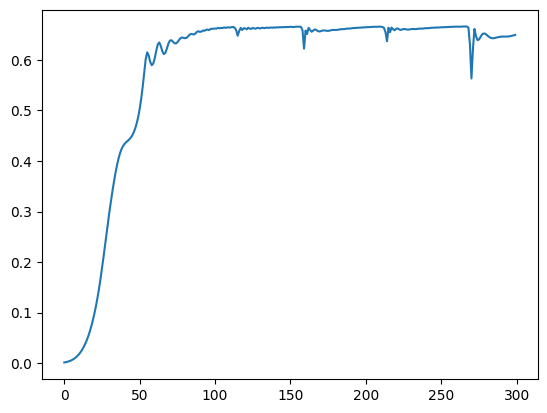

In [5]:
# %%
@jax.jit
def update(_params, _opt_state):
    _val, _grad = jax.value_and_grad(loss_fn)(_params)
    _updates, _opt_state = optimizer.update(_grad, _opt_state)
    _params = optax.apply_updates(_params, _updates)
    return _params, _opt_state, _val


# %%
df = []
update(params, opt_state)
n_steps = 300
pbar = tqdm.tqdm(range(n_steps), desc="Training", unit="it")
for step in pbar:
    params, opt_state, val = update(params, opt_state)

    pbar.set_postfix({"loss": val})
    pbar.update(1)

    df.append({"cfim": val, "step": step})

df = pl.DataFrame(df)

# %%
fig, ax = plt.subplots()
ax.plot(df["step"], df["cfim"])
fig.show()

# %%
prob = sim.prob.forward(params)
print_nonzero_entries(prob)
eqx.tree_pprint(params, short_arrays=False)

In [6]:
# # we next compute the classical Fisher information
# cfi = jnp.sum(get(grad)**2 / (prob + 1e-14))
# print(f"The classical Fisher information for `phi` is {cfi}")

# # this can also be performed from the `sim` object
# cfim = sim.prob.cfim(get, params)
# print(f"The classical Fisher information is {cfim}")

In [7]:
# phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
# params = eqx.tree_at(
#     lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
# )

# probs = eqx.filter_vmap(sim.prob.forward)(params)


In [8]:
# colors = cycle(sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:]))))
# styles = cycle(['--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted'])
# fig, ax = plt.subplots()
# for i, idx in enumerate(
#     itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
# ):
#     if jnp.mean(probs[:, *idx]) < 1e-6:
#         continue
#     label = f"{idx}" if jnp.mean(probs[:, *idx]) > 1e-6 else None
#     # print(label, jnp.mean(probs[:, *idx]))
#     ax.plot(phis, probs[:, *idx], label=label, color=next(colors), ls=next(styles), alpha=0.8)
# ax.legend()
# ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")
